# Natural Language Processing(CS 833) Assignment 1
 
### The goal of this assignment is to underatand how n-gram models work and how smoothing techniques can handle unseen sequences in a dataset


## 0) Necessary Setup

In [1]:
import os 
import re
import math
import random
from collections import Counter
from typing import List, Tuple, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
random.seed(100)
os.makedirs("Results", exist_ok=True) # All the results are saved here

In [4]:
results_path = './Results/'

## 1) Data Setup (Load data after downlaoding from kaggle)

In [5]:
data_path = 'dataset/all-data.csv'

In [6]:
df_news = pd.read_csv(data_path, encoding="utf-8", 
                      names=["sentiment", "text"], #making column names
                      encoding_errors="replace")

In [7]:
df_news.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [8]:
sample_data = df_news.iloc[1000]['text']
sample_data

"Incap Corporation Stock Exchange Release 4 May 2010 at 8.30 a.m. INCAP CORPORATION 'S DIRECTED SHARE ISSUE WAS SUBSCRIBED IN FULL The Board of Incap Corporation has approved the subscriptions of directed share issue ."

In [9]:
df_news.describe()

,sentiment,text
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [10]:
df_news.sentiment.value_counts()


sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

In [11]:
def tokenize_text(text):
    """
    Tokenizes text into a list of words.
    Args:
        text (str): Input text to tokenize.
    Returns:
        list: List of tokenized strings.
    """
    text = text.lower()
    tokens = re.split(r'[^a-z0-9\']+', text)
    tokenized_list =  [t for t in tokens if t and t != "'"]
    return tokenized_list
    

In [12]:
sample_data1 = tokenize_text(sample_data)
print(sample_data1)

['incap', 'corporation', 'stock', 'exchange', 'release', '4', 'may', '2010', 'at', '8', '30', 'a', 'm', 'incap', 'corporation', "'s", 'directed', 'share', 'issue', 'was', 'subscribed', 'in', 'full', 'the', 'board', 'of', 'incap', 'corporation', 'has', 'approved', 'the', 'subscriptions', 'of', 'directed', 'share', 'issue']


In [13]:
def add_startend(tokens, n):
    res = []
    for _ in range(n - 1):
        res.append("<s>")
    for t in tokens:
        res.append(t)
    res.append("</s>")
    return res


In [14]:
sample_data2 = add_startend(sample_data1,3)

In [15]:
print(sample_data2)

['<s>', '<s>', 'incap', 'corporation', 'stock', 'exchange', 'release', '4', 'may', '2010', 'at', '8', '30', 'a', 'm', 'incap', 'corporation', "'s", 'directed', 'share', 'issue', 'was', 'subscribed', 'in', 'full', 'the', 'board', 'of', 'incap', 'corporation', 'has', 'approved', 'the', 'subscriptions', 'of', 'directed', 'share', 'issue', '</s>']


In [16]:
def preprocess_sentiment(text,n, start_end=False):
    """
    Preprocess text by tokenizing and adding sentence markers.
    
    Args:
        text (str): Input text to preprocess.
        n (int): N-gram order for sentence markers (eg use 3 for trigrams)
        add_startend(Boolean): whether to add tokens at start and end
    
    Returns:
        List[str]: Tokenized text with start and end markers.
    """
    tokens = tokenize_text(text)
    if start_end:
        tokens =  add_startend(tokens, n)
    return tokens

In [17]:
df_news['tokens'] = df_news['text'].apply(lambda x: preprocess_sentiment(x, n=3))

In [18]:
df_news.head()

,sentiment,text,tokens
0,neutral,"According to Gran , the company has no plans t...","[according, to, gran, the, company, has, no, p..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ..."
2,negative,The international electronic industry company ...,"[the, international, electronic, industry, com..."
3,positive,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa..."
4,positive,According to the company 's updated strategy f...,"[according, to, the, company, 's, updated, str..."


In [19]:
df_news['tokens2'] = df_news['text'].apply(lambda x: preprocess_sentiment(x, n=2, start_end=True))

In [20]:
df_news.head()

,sentiment,text,tokens,tokens2
0,neutral,"According to Gran , the company has no plans t...","[according, to, gran, the, company, has, no, p...","[<s>, according, to, gran, the, company, has, ..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[<s>, technopolis, plans, to, develop, in, sta..."
2,negative,The international electronic industry company ...,"[the, international, electronic, industry, com...","[<s>, the, international, electronic, industry..."
3,positive,With the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[<s>, with, the, new, production, plant, the, ..."
4,positive,According to the company 's updated strategy f...,"[according, to, the, company, 's, updated, str...","[<s>, according, to, the, company, 's, updated..."


#  Task 1: N-gram Generation
## Identify and Generate unigrams, bigrams, and trigrams, calculate their frequencies,
## and visualize the top 10 most frequent n-grams.

In [21]:
def ngram_generation(tokens, n):
    """
    Generate n-grams from a list of tokens
    Args:
        tokens: List of tokens to generate n-grams from.
        n: Size of n-grams (e.g. 1 for unigrams).
    Returns:
        List of n-gram tuples.
    """
    ngs = []
    for i in range(len(tokens) - n + 1):
        ng = tuple(tokens[i:i + n])
        ngs.append(ng)
    return ngs


### Generate unigrams, bigrams, and trigrams

In [22]:
combined_tokens = [token for tokens in df_news['tokens'] for token in tokens]

In [23]:
unigrams = ngram_generation(combined_tokens, 1)
bigrams = ngram_generation(combined_tokens, 2)
trigrams = ngram_generation(combined_tokens, 3)


In [24]:
# Calculate frequency distributions
unigram_freq = Counter(unigrams)
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

In [25]:
 #Convert tuples to strings(for visualization)
unigram_freq = {k[0]: v for k, v in unigram_freq.items()}
bigram_freq = {' '.join(k): v for k, v in bigram_freq.items()}
trigram_freq = {' '.join(k): v for k, v in trigram_freq.items()}


In [26]:
def get_ngram_table(ngram_freq, title, top_n = 10):
    """
    Print a table of the top n most frequent n-grams using pandas DataFrame. 
    Args:
        ngram_freq: Dictionary of n-grams and their frequencies.
        title : Title of the table.
        top_n: Number of top n-grams to display (default: 10).
    """
    top_ngrams = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    df_ngrams = pd.DataFrame(top_ngrams, columns=['N-gram', 'Frequency'])
    print(f"\n{title}")
    print(df_ngrams)

In [27]:
# Print frequency tables
get_ngram_table(unigram_freq, 'Top 10 Unigrams Table')
get_ngram_table(bigram_freq, 'Top 10 Bigrams Table')
get_ngram_table(trigram_freq, 'Top 10 Trigrams Table')


Top 10 Unigrams Table
  N-gram  Frequency
0    the       6069
1     of       3215
2     in       2984
3    and       2596
4     to       2523
5      a       1748
6    for       1152
7    eur       1018
8     's       1000
9     is        930

Top 10 Bigrams Table
        N-gram  Frequency
0       in the        804
1       of the        719
2  the company        504
3      for the        357
4      will be        272
5    net sales        246
6       to the        242
7       to eur        227
8     from eur        210
9        mn in        196

Top 10 Trigrams Table
                     N-gram  Frequency
0            the company 's        131
1                 mn in the        122
2  the corresponding period        108
3   corresponding period in         87
4                as well as         82
5              in the first         76
6               mn from eur         73
7      in the corresponding         73
8                the end of         68
9              net sales of         

In [28]:
def plot_wordcount(ngram_freq, title, label='unigram_mostfrequent',top_n = 10):
    """
    Plot word count in  bar chart of the top n most frequent n-grams.
    Args:
        ngram_freq: Dictionary of n-grams and their frequencies.
        title: Title of the plot.
        top_n: Number of top n-grams to display (default: 10).
    """
    top_ngrams = dict(sorted(ngram_freq.items(), 
                             key=lambda x: x[1], 
                             reverse=True)[:top_n])
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_ngrams.values()), y=list(top_ngrams.keys()))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.savefig(f"{results_path}/{label}_.pdf", dpi=300, bbox_inches="tight") 
    plt.show()

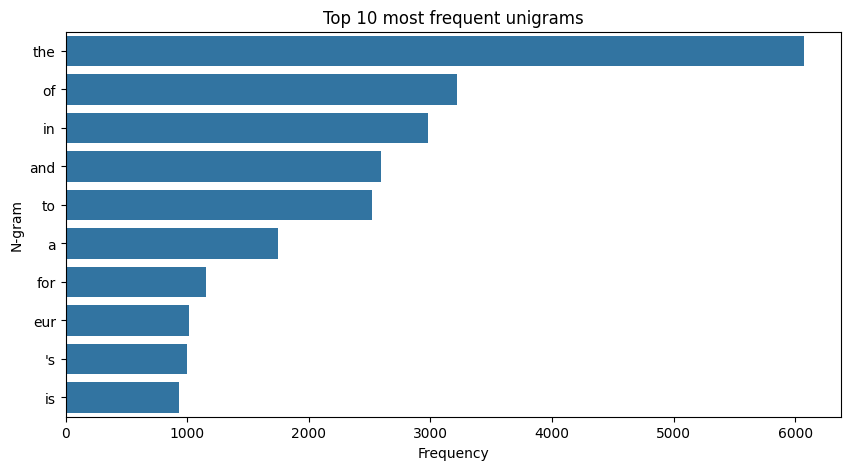

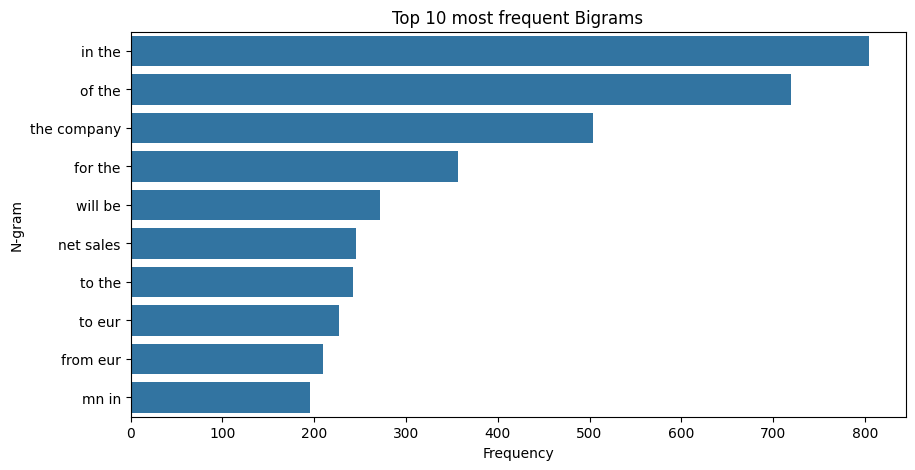

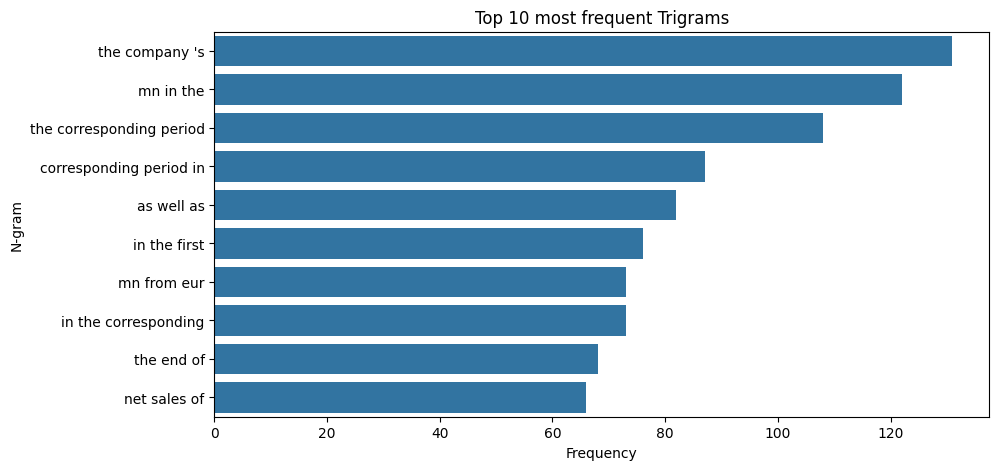

In [29]:
 #plot bargraph
plot_wordcount(unigram_freq, 'Top 10 most frequent unigrams','unigram_mostfrequent')
plot_wordcount(bigram_freq,  'Top 10 most frequent Bigrams', 'bigram_mostfrequent')
plot_wordcount(trigram_freq, 'Top 10 most frequent Trigrams', 'triigram_mostfrequent')

#  Task 2: N-Gram Modeling 
## Split data, Train ngram models, evaluate performance 

In [30]:
def split_df(df):
    X = df[['text', 'tokens']].copy()
    y = df['sentiment'].copy()  # values: "positive", "negative", "neutral"
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y # To force even distribution of 3 classes
    )
    
    train_df = X_train.copy()
    train_df['sentiment'] = y_train.values
    
    test_df = X_test.copy()
    test_df['sentiment'] = y_test.values
    return train_df, test_df

In [31]:
train_df_news, test_df_news = split_df(df_news)

In [32]:
print('Distribution of classes for entire data:',df_news['sentiment'].value_counts())

Distribution of classes for entire data: sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64


In [33]:
print('shape of train data:',train_df_news.shape)
print('shape of test data:',test_df_news.shape)

shape of train data: (3876, 3)
shape of test data: (970, 3)


In [34]:
print('Distribution of classes for train data:',train_df_news['sentiment'].value_counts())
print('')
print('Distribution of classes for test data:',test_df_news['sentiment'].value_counts())

Distribution of classes for train data: sentiment
neutral     2303
positive    1090
negative     483
Name: count, dtype: int64

Distribution of classes for test data: sentiment
neutral     576
positive    273
negative    121
Name: count, dtype: int64


In [35]:
# Collect all tokens from training data for n-gram generation
combined_tokens_train = train_df_news['tokens'].explode().tolist()

In [36]:
len(combined_tokens_train)

82444

## Train ngram model

In [37]:
def ngram_models_train(tokens, n):
    """
    Train an n-gram model by counting n-grams and their contexts.
    
    Args:
        tokens: List of tokens to train on.
        n: N-gram order (e.g., 1 for unigram, 2 for bigram).
    
    Returns:
        N-gram counts and context (n-1)-gram counts.
    """
    ngrams = ngram_generation(tokens, n)
    ngram_counts = Counter(ngrams)
    if n > 1:
        context_counts = Counter(ngram_generation(tokens, n - 1))
    else:
        total = sum(ngram_counts.values())
        context_counts = Counter({(): total})
    return ngram_counts, context_counts

In [38]:
def ngram_prob_calculation(ngram, ngram_counts, context_counts, vocab_size):
    """
    Calculate the conditional probability of an n-gram: 
    
    Args:
        ngram: The n-gram to compute probability for.
        ngram_counts: Counts of n-grams.
        context_counts: Counts of (n-1)-gram contexts.
        vocab_size: Size of the vocabulary.
    
    Returns:
       Conditional probability, with small value for unseen n-grams.
    """
    count = ngram_counts.get(ngram, 0)
    context = ngram[:-1]
    context_count = context_counts.get(context, vocab_size)
    if context_count > 0:
        prob = count / context_count
    else:
        prob = 1e-10 # small value for unseen n-grams.
    if prob <= 0:
        return 1e-10
    return prob

In [39]:
# tokens = preprocess_sentiment(text, n,start_end=True)

In [40]:
def calculate_perplexity(n, ngram_counts, context_counts, vocab_size, prob_func, 
                         test_df = None, sentence = None, track_unseen = False, label: str = ""):
    """
    Calculate perplexity using the natural logarithm of probabilities.
    
    Args:
        n (int): N-gram order (1 for unigram, 2 for bigram, 3 for trigram).
        ngram_counts (Counter): Counts of n-grams from training.
        context_counts (Counter): Counts of (n-1)-gram contexts.
        vocab_size (int): Size of the vocabulary.
        prob_func (Callable): Function to compute n-gram probability
        test_df (pd.DataFrame, optional): Test DataFrame with 'text' column for test-set perplexity.
        sentence (str, optional): Single sentence for perplexity calculation.
        track_unseen (bool): Whether to track and print unseen n-grams (for unsmoothed models).
        label (str): Label for debug prints
    
    Returns:
        float: Perplexity score (average for test set, single value for sentence).
    """
    
    def compute_single_perplexity(text):
        tokens = preprocess_sentiment(text, n,start_end=True)
        ngrams = ngram_generation(tokens, n)

        
        log_prob_sum = 0.0
        ngram_count = 0
        unseen_ngrams = 0
        for ng in ngrams:
            p = prob_func(ng, ngram_counts, context_counts, vocab_size)
            if track_unseen and p == 1e-10:
                unseen_ngrams += 1
            log_prob_sum += math.log(p)
            ngram_count += 1
        
        perplexity = math.exp(-log_prob_sum / ngram_count)
        if track_unseen and unseen_ngrams > 0:
            print(f"Text {label}: {text[:50]!s:<50} Unseen n-grams: {unseen_ngrams}/{ngram_count}")
        return perplexity
    
    if sentence is not None:
        return compute_single_perplexity(sentence)
    
    # Process test set
    perplexities = []
    for text in test_df['text']:
        perplexity = compute_single_perplexity(text)
        if perplexity != float('inf'):
            perplexities.append(perplexity)
    
    return np.mean(perplexities) if perplexities else float('inf')

In [41]:
# get vocab
vocab = set(combined_tokens_train)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9005


In [42]:
# Train unigram, bigram, and trigram models
unigram_counts, unigram_contexts = ngram_models_train(combined_tokens_train, 1)
bigram_counts, bigram_contexts = ngram_models_train(combined_tokens_train, 2)
trigram_counts, trigram_contexts = ngram_models_train(combined_tokens_train, 3)

In [43]:
# Calculate perplexity on test set (Task 2: Unsmoothed)
unigram_perplexity = calculate_perplexity(1, unigram_counts, unigram_contexts, vocab_size, ngram_prob_calculation, test_df=test_df_news)
bigram_perplexity = calculate_perplexity(2, bigram_counts, bigram_contexts, vocab_size, ngram_prob_calculation, test_df=test_df_news)
trigram_perplexity = calculate_perplexity(3, trigram_counts, trigram_contexts, vocab_size, ngram_prob_calculation, test_df=test_df_news)

In [44]:
unigram_contexts

Counter({(): 82444})

In [45]:
# bigram_counts

In [46]:
comparison_data1 =  np.array([unigram_perplexity, bigram_perplexity, trigram_perplexity])
comparison_data1

array([5.78012681e+04, 1.04737975e+08, 2.03330424e+09])

In [47]:
# Visualize perplexity comparison
def plot_comparison(comparison_data, label='Test data'):
    plt.figure(figsize=(8, 5))
    plt.bar(['Unigram', 'Bigram', 'Trigram'], comparison_data)
    plt.yscale("log") 
    plt.title(f'Perplexity(in log base 10 for  visualization) of N-Gram Models (Unsmoothed) in {label}')
    plt.ylabel('Perplexity')
    plt.savefig(f"{results_path}/comparison_among_unsmoothed_.pdf", dpi=300, bbox_inches="tight") 
    plt.show()

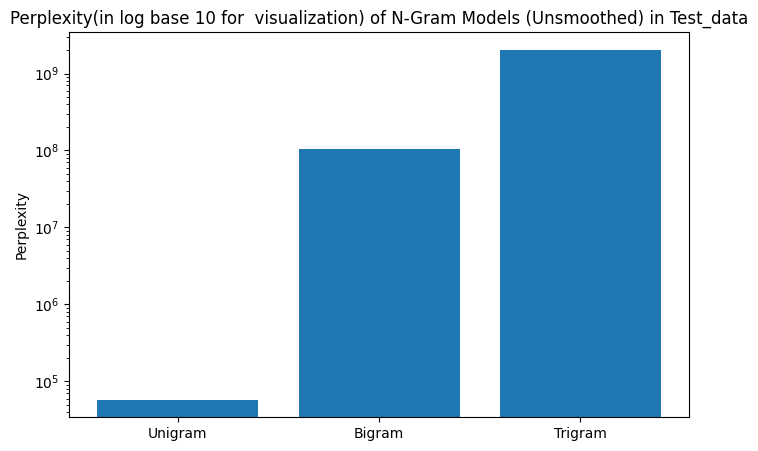

In [48]:
plot_comparison(comparison_data1, label='Test_data')

In [49]:
unseen_sentence = 'NLP is interesting. I love NLP'

In [50]:
# Calculate perplexity on test set (Task 2: Unsmoothed)
unigram_perplexity2 = calculate_perplexity(1, unigram_counts, unigram_contexts, vocab_size, ngram_prob_calculation, sentence=unseen_sentence, track_unseen=True)
bigram_perplexity2 = calculate_perplexity(2, bigram_counts, bigram_contexts, vocab_size, ngram_prob_calculation, sentence=unseen_sentence, track_unseen=True)
trigram_perplexity2 = calculate_perplexity(3, trigram_counts, trigram_contexts, vocab_size, ngram_prob_calculation, sentence=unseen_sentence, track_unseen=True)


Text : NLP is interesting. I love NLP                     Unseen n-grams: 3/7
Text : NLP is interesting. I love NLP                     Unseen n-grams: 7/7
Text : NLP is interesting. I love NLP                     Unseen n-grams: 7/7


In [51]:
comparison_data2 =  [unigram_perplexity2, bigram_perplexity2, trigram_perplexity2]
comparison_data2

[2068625.4695181947, 9999999999.999968, 9999999999.999968]

# Task 3: Handling Unseen N-grams
## Objective: Apply Laplace smoothing to n-gram models, recalculate perplexity 
## and compare with unsmoothed models.

In [52]:
def ngram_prob_calculation_laplace(ngram, ngram_counts, context_counts, vocab_size):
    """
    Calculate Laplace-smoothed conditional probability for an n-gram.
    
    Args:
        ngram (Tuple[str, ...]): The n-gram to compute probability for.
        ngram_counts (Counter): Counts of n-grams.
        context_counts (Counter): Counts of (n-1)-gram contexts.
        vocab_size (int): Size of the vocabulary.
    
    Returns:
        float: Smoothed conditional probability (non-zero for unseen n-grams).
    """
    count = ngram_counts.get(ngram, 0) + 1
    context = ngram[:-1]
    context_count = context_counts.get(context, 0) + vocab_size
    laplace_prob=  count / context_count
    return laplace_prob

In [53]:
unigram_perplexity_laplace = calculate_perplexity(1, unigram_counts, unigram_contexts, vocab_size, ngram_prob_calculation_laplace, test_df=test_df_news, label="(Laplace)")
bigram_perplexity_laplace = calculate_perplexity(2, bigram_counts, bigram_contexts, vocab_size, ngram_prob_calculation_laplace, test_df=test_df_news, label="(Laplace)")
trigram_perplexity_laplace = calculate_perplexity(3, trigram_counts, trigram_contexts, vocab_size, ngram_prob_calculation_laplace, test_df=test_df_news, label="(Laplace)")

In [54]:
comparison_data_laplace1 = np.array([unigram_perplexity_laplace,bigram_perplexity_laplace,trigram_perplexity_laplace])

In [55]:
comparison_data_laplace1

array([1794.87896661, 3447.6342777 , 6700.12780524])

In [56]:
# Visualize comparison of unsmoothed vs. smoothed perplexity
def plot_comparison_both(before,after):
    plt.figure(figsize=(10, 6))
    models = ['Unigram', 'Bigram', 'Trigram']
    x = np.arange(len(models))
    width = 0.35
    plt.bar(x - width/2, before, width, label='Unsmoothed')
    plt.bar(x + width/2, after, width, label='Laplace Smoothed')
    plt.yscale('log', base=10)
    plt.xlabel('N-Gram Model')
    plt.ylabel('Perplexity(log scaled)')
    plt.title('Perplexity Comparison: Unsmoothed vs. Laplace Smoothed  in Test Data')
    plt.xticks(x, models)
    plt.legend()
    plt.savefig(f"{results_path}/comparison_among_smoothed_Unsmoothed_.pdf", dpi=300, bbox_inches="tight") 
    plt.show()

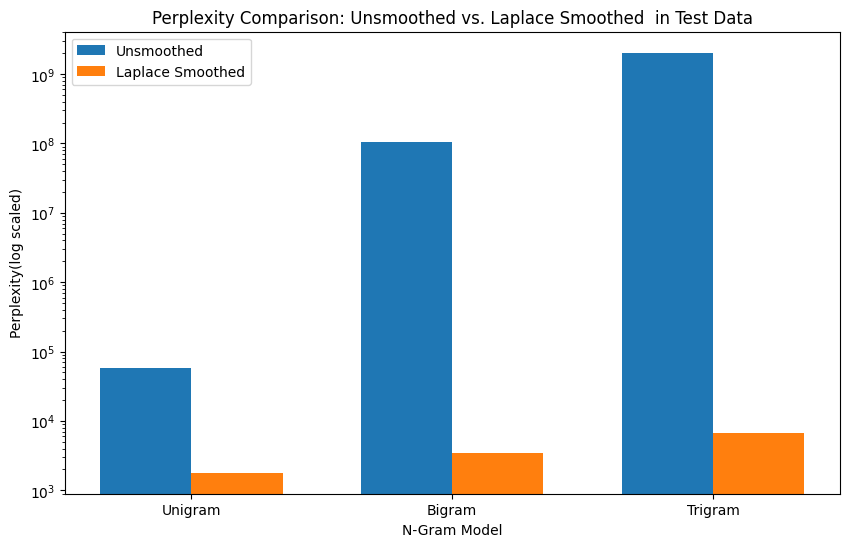

In [57]:
plot_comparison_both(comparison_data1,comparison_data_laplace1)

# Task 4: Interpolation
## Combine unigram, bigram, and trigram models using linear interpolation
## with weights [0.1, 0.2, 0.7], calculate perplexity, and compare with other models.

In [58]:
def get_interpolated_prob(ngram, models, weights, vocab_size):
    """
    Calculate interpolated probability combining unigram, bigram, and trigram probabilities.
    
    Args:
        ngram : The n-gram to compute probability.
        models : List of (ngram_counts, context_counts) for unigram, bigram, trigram.
        weights: Weights for unigram, bigram, trigram 
        vocab_size: Size of the vocabulary.
    
    Returns:
        Interpolated probability.
    """
    prob = 0.0
    for i, (ngram_counts, context_counts) in enumerate(models, 1):
        prob += weights[i-1] * ngram_prob_calculation_laplace(ngram[-i:], ngram_counts, context_counts, vocab_size)
    return prob

def calculate_perplexity_interpolated(test_tokens, models, weights, vocab_size):
    """
    Calculate perplexity for the interpolated model.
    
    Args:
        test_tokens: Test tokens to evaluate.
        models : List of (ngram_counts, context_counts) for unigram, bigram, trigram.
        weights : Weights for unigram, bigram, trigram.
        vocab_size : Size of the vocabulary.
    
    Returns:
        float: Perplexity score for the interpolated model.
    """
    n = len(models)
    ngrams = ngram_generation(test_tokens, n)
    log_prob_sum = 0
    total_ngrams = len(ngrams)
    for ngram in ngrams:
        prob = get_interpolated_prob(ngram, models, weights, vocab_size)
        log_prob_sum += np.log2(prob if prob > 0 else 1e-10)
    avg_log_prob = -log_prob_sum / total_ngrams if total_ngrams > 0 else 0
    return 2 ** avg_log_prob

In [59]:
# Interpolation weights
weights = [0.1, 0.2, 0.7]  # [unigram, bigram, trigram]
models = [
    (unigram_counts, unigram_contexts),
    (bigram_counts, bigram_contexts),
    (trigram_counts, trigram_contexts)
]


In [60]:
# Calculate perplexity with interpolation
test_tokens = [token for tokens in test_df_news['tokens'] for token in tokens]

In [61]:
len(test_tokens)

20974

In [62]:
interpolated_perplexity = calculate_perplexity_interpolated(test_tokens, models, weights, vocab_size)

In [63]:
interpolated_perplexity

2044.5937955049196

In [64]:
def plot_perplexity_grouped(
    unigram_perplexity,
    bigram_perplexity,
    trigram_perplexity,
    unigram_perplexity_laplace=None,
    bigram_perplexity_laplace=None,
    trigram_perplexity_laplace=None,
    interpolated_perplexity=None,
    log_scale=True,
    ax=None,
    title="Perplexity Comparison of test data across Models"
):
    """
    Plots vertical grouped bars for three groups:
      - 'Unsmooth'       
      - 'Laplace smooth' 
      - 'Interpolated'   (single combined value)
    Series are Unigram, Bigram, Trigram, and  Interpolated.
    """

    # Assemble data in (group -> series -> value) form
    data = {
        "Unsmooth": {
            "Unigram": unigram_perplexity,
            "Bigram": bigram_perplexity,
            "Trigram": trigram_perplexity,
            "Interpolated": None,
        },
        "Laplace smooth": {
            "Unigram": unigram_perplexity_laplace,
            "Bigram": bigram_perplexity_laplace,
            "Trigram": trigram_perplexity_laplace,
            "Interpolated": None,
        },
        "Interpolated": {
            "Unigram": None,
            "Bigram": None,
            "Trigram": None,
            "Interpolated": interpolated_perplexity,
        },
    }

    groups = list(data.keys())
    series = ["Unigram", "Bigram", "Trigram", "Interpolated"]

    def human_readable(v):
        if v is None: return ""
        if v >= 1e9:  return f"{v/1e9:.1f}B"
        if v >= 1e6:  return f"{v/1e6:.1f}M"
        if v >= 1e3:  return f"{v/1e3:.1f}k"
        return f"{v:.0f}"

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5.5))

    x = np.arange(len(groups))
    bar_w = 0.18
    gap = 1.15
    offsets = (np.arange(len(series)) - (len(series) - 1) / 2) * bar_w * gap

    # Track which series actually plotted (for legend)
    plotted_series = []

    for s_idx, s in enumerate(series):
        xs, heights = [], []
        for i, g in enumerate(groups):
            v = data[g].get(s)
            if v is None or v <= 0:
                continue
            xs.append(x[i] + offsets[s_idx])
            heights.append(v)

        if heights:
            bars = ax.bar(xs, heights, width=bar_w, label=s)
            if s not in plotted_series:
                plotted_series.append(s)
            # Add value labels
            for rect, v in zip(bars, heights):
                ax.text(rect.get_x() + rect.get_width()/2, v,
                        human_readable(v),
                        ha="center", va="bottom", fontsize=9, rotation=90)

    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.set_xlabel("Group")
    ax.set_ylabel("Perplexity" + (" (log scale)" if log_scale else ""))
    ax.set_title(title)
    if log_scale:
        ax.set_yscale("log")
        ax.grid(axis="y", which="both", linestyle="--", alpha=0.4)
    else:
        ax.grid(axis="y", linestyle="--", alpha=0.4)

    if plotted_series:
        ax.legend(title="Model", ncol=2, frameon=False)

    plt.tight_layout()
    plt.savefig(f"{results_path}/comparison_all_.pdf", dpi=300, bbox_inches="tight") 
    return ax

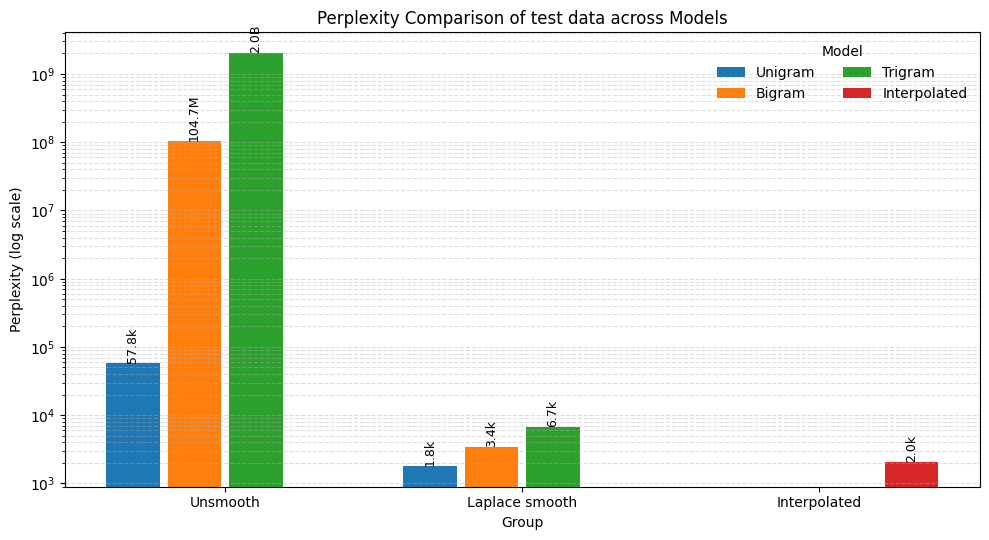

In [65]:
plot_perplexity_grouped(
    unigram_perplexity,
    bigram_perplexity,
    trigram_perplexity,
    unigram_perplexity_laplace,     
    bigram_perplexity_laplace,       
    trigram_perplexity_laplace,      
    interpolated_perplexity,                    
    log_scale=True
)
plt.show()